\:# Neural Survival Clustering on METABRIC Dataset

In [1]:
import sys
sys.path.append('../')
sys.path.append('/content/gdrive/My Drive/NeuralSurvivalClustering/DeepSurvivalMachines/')
print(sys.executable)

/usr/bin/python3


In [2]:
!pip install pyspark
!pip install nose
!pip install scikit-survival
!pip install pycox
!pip install tqdm
!pip install lifelines


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.8 MB/s eta 0:00:00
  Attempting uninstall: osqp
    Found existing installation: osqp 1.0.3
    Uninstalling osqp-1.0.3:
      Successfully uninstalled osqp-1.0.3
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
#!apt-get install -y build-essential
#!export SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=Tru
#!pip install sklearn==0.0
#!pip install pysurvival

In [4]:
# View and modify the working path
import os
from google.colab import drive

# View current working directory
print("Current Working Directory:", os.getcwd())

# Mount Google Drive
drive.mount('/content/gdrive')

# Change working directory to your file position
path = "/content/gdrive/My Drive/NeuralSurvivalClustering"
os.chdir(path)

# Confirm the change
print("Working Directory:", os.getcwd())

Current Working Directory: /content
Mounted at /content/gdrive
Working Directory: /content/gdrive/My Drive/NeuralSurvivalClustering


### Load the SUPPORT Dataset

The package includes helper functions to load the dataset.

X represents an np.array of features (covariates),
T is the event/censoring times and,
E is the censoring indicator.

In [5]:
from nsc import datasets
x, t, e, columns = datasets.load_dataset('METABRIC')

Dataset 'metabric' not locally available. Downloading...
Done


In [6]:
print(x.shape)
print(t.shape)
print(e.shape)


(1904, 9)
(1904,)
(1904,)


### Compute horizons at which we evaluate the performance of NSC

Survival predictions are issued at certain time horizons. Here we will evaluate the performance
of NSC to issue predictions at the 25th, 50th and 75th event time quantile as is standard practice in Survival Analysis.

In [7]:
import numpy as np
import torch
np.random.seed(42)
torch.random.manual_seed(42)

horizons = [0.25, 0.5, 0.75]
times = np.quantile(t[e!=0], horizons).tolist()

In [8]:
# Display the percentage of observed event at different time horizon
for time in times:
    print('At time {:.2f}'.format(time))
    for risk in np.unique(e):
        print('\t {:.2f} % observed risk {}'.format(100 * ((e == risk) & (t < time)).mean(), risk))

At time 42.68
	 2.05 % observed risk 0
	 14.50 % observed risk 1
At time 85.87
	 6.83 % observed risk 0
	 28.94 % observed risk 1
At time 145.33
	 18.86 % observed risk 0
	 43.43 % observed risk 1


### Splitting the data into train, test and validation sets

We will train NSC on 80% of the Data (10 % of which is used for stopping criterion and 10% for model Selection) and report performance on the remaining 20% held out test set.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

x_train, x_test, t_train, t_test, e_train, e_test = train_test_split(x, t, e, test_size = 0.2, random_state = 42)
x_train, x_val, t_train, t_val, e_train, e_val = train_test_split(x_train, t_train, e_train, test_size = 0.2, random_state = 42)
x_dev, x_val, t_dev, t_val, e_dev, e_val = train_test_split(x_val, t_val, e_val, test_size = 0.5, random_state = 42)

minmax = lambda x: x / t_train.max() # Enforce to be inferior to 1
t_train_ddh = minmax(t_train)
t_dev_ddh = minmax(t_dev)
t_val_ddh = minmax(t_val)
times_ddh = minmax(np.array(times))

### Setting the parameter grid

Lets set up the parameter grid to tune hyper-parameters. We will tune the number of underlying survival distributions,
($K$), the latent representation, the learning rate for the Adam optimizer and the number of hidden layers and nodes.

In [10]:
from sklearn.model_selection import ParameterSampler

In [11]:
layers = [[50], [50, 50], [50, 50, 50], [100], [100, 100], [100, 100, 100]]
param_grid = {
            'learning_rate' : [1e-3, 1e-4],
            'layers_surv': layers,
            'k': [2, 3, 4, 5],
            'representation': [50, 100],
            'layers' : layers,
            'act': ['Tanh'],
            'batch': [100, 250],
            }
params = ParameterSampler(param_grid, 10, random_state = 42)

### Model Training and Selection

In [12]:
from nsc import NeuralSurvivalCluster

In [13]:
models = []
for param in params:
    model = NeuralSurvivalCluster(layers = param['layers'], act = param['act'], k = param['k'],
                                layers_surv = param['layers_surv'], representation = param['representation'])
    # The fit method is called to train the model
    model.fit(x_train, t_train_ddh, e_train, n_iter = 10, bs = param['batch'],
            lr = param['learning_rate'], val_data = (x_dev, t_dev_ddh, e_dev))
    nll = model.compute_nll(x_val, t_val_ddh, e_val)
    if not(np.isnan(nll)):
        models.append([nll, model])
    else:
        print("WARNING: Nan Value Observed")

Loss: 0.306: 100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


In [14]:
best_model = min(models, key = lambda x: x[0])
model = best_model[1]

### Inference

Model prediction for the different patients and analysis of the results

In [15]:
out_risk = model.predict_risk(x_test, times_ddh.tolist())
out_survival = model.predict_survival(x_test, times_ddh.tolist())

### Evaluation

We evaluate the performance of NSC in its discriminative ability (Time Dependent Concordance Index and Cumulative Dynamic AUC) as well as Brier Score.

In [16]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [17]:
et_train = np.array([(e_train[i] == 1, t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i] == 1, t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
selection = (t_test < t_train.max()) | (e_test == 0)

cis = []
for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test[selection], out_risk[:, i][selection], times[i])[0])
brs = brier_score(et_train, et_test[selection], out_survival[selection], times)[1]
#roc_auc = []
#for i, _ in enumerate(times):
#    roc_auc.append(cumulative_dynamic_auc(et_train, et_test[selection], out_risk[:, i][selection], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[horizon[0]])
#    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.5974393310718945
Brier Score: 0.12463908854543555
For 0.5 quantile,
TD Concordance Index: 0.6029202046482282
Brier Score: 0.2057834348484512
For 0.75 quantile,
TD Concordance Index: 0.6217115955135499
Brier Score: 0.22283600561651343


## Cluster analysis

In this section, we display the learnt clusters and the impact of the different features on the membership to each cluster. This importance is obtained through permutation of the feature.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
times_cluster = np.quantile(t, np.linspace(0, 1, 100))
clusters = model.survival_cluster(minmax(times_cluster).tolist(), 1)

In [20]:
print(clusters)

[[1.         1.        ]
 [0.99014064 0.96093303]
 [0.97890847 0.91841442]
 [0.97177999 0.89247404]
 [0.96800668 0.87905853]
 [0.96308346 0.86187404]
 [0.95901921 0.84795431]
 [0.95465516 0.83326999]
 [0.95127834 0.82209019]
 [0.94637038 0.80611923]
 [0.94186719 0.79174903]
 [0.93853947 0.78130061]
 [0.93279386 0.76359423]
 [0.93005074 0.75528693]
 [0.92556993 0.74191613]
 [0.92188828 0.73111143]
 [0.91622827 0.71481292]
 [0.91449828 0.70990539]
 [0.91058566 0.69893198]
 [0.90671675 0.68824997]
 [0.90170415 0.67465481]
 [0.89769259 0.66396956]
 [0.89231681 0.64991608]
 [0.88754707 0.63769599]
 [0.88278821 0.62573179]
 [0.8769447  0.61134494]
 [0.87337467 0.6027169 ]
 [0.86967445 0.59390093]
 [0.86288427 0.57805134]
 [0.8573513  0.56544316]
 [0.85350694 0.55684121]
 [0.84767788 0.54404052]
 [0.84174885 0.5313128 ]
 [0.83675702 0.52082013]
 [0.83222818 0.51147321]
 [0.82675401 0.50038969]
 [0.82433268 0.49556077]
 [0.81977665 0.48659464]
 [0.81612392 0.47951775]
 [0.81318772 0.47389994]


Text(0, 0.5, 'Time')

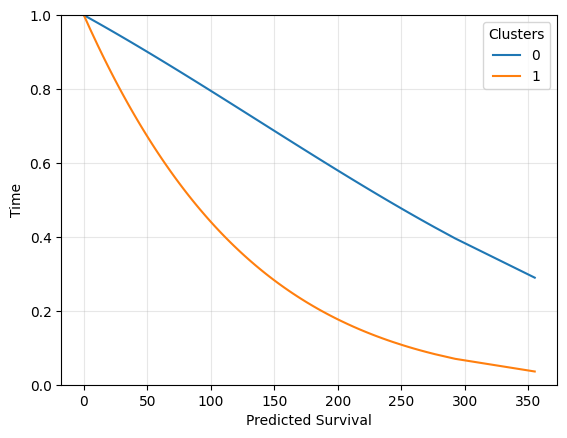

In [21]:
pd.DataFrame(clusters, index = times_cluster).plot()
plt.grid(alpha = 0.3)
plt.ylim(0, 1)
plt.legend(title = 'Clusters')
plt.xlabel('Predicted Survival')
plt.ylabel('Time')

**DSM replication results**

In [22]:
from dsm import DeepSurvivalMachines

In [23]:
print(x_train,t_train,e_train)

[[-0.11391025  0.7853412  -0.49847645 ... -0.51244462  0.56360185
   0.4449181 ]
 [ 0.25049621  1.69177973 -0.77598041 ... -0.51244462  0.56360185
  -1.5419333 ]
 [ 0.79821301 -0.32165065 -0.57388824 ... -0.51244462  0.56360185
  -0.47220901]
 ...
 [-0.60389632  1.06333315 -0.66111588 ... -0.51244462  0.56360185
   0.48114085]
 [-0.2844106  -0.14898811 -0.45819521 ... -0.51244462  0.56360185
   0.56900001]
 [-0.49016497  0.5640583   0.32380703 ... -0.51244462  0.56360185
   0.34626922]] [172.8999939   56.76666641 125.33333588 ... 127.83333588  31.
 256.5       ] [1 1 1 ... 1 1 0]


In [24]:
from sklearn.model_selection import ParameterGrid
param_grid = {'k' : [3, 4, 6],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [ 1e-4, 1e-3],
              'layers' : [ [], [100], [100, 100] ]
             }
params = ParameterGrid(param_grid)

models = []
for param in params:
    model = DeepSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 layers = param['layers'])
    # The fit method is called to train the model
    model.fit(x_train, t_train, e_train, iters = 100, learning_rate = param['learning_rate'])
    models.append([[model.compute_nll(x_val, t_val, e_val), model]])
best_model = min(models)
model_dsm = best_model[0][1]

 17%|█▋        | 17/100 [00:00<00:04, 20.36it/s]


In [25]:

# Predict risk scores for new data
risk_scores_dsm = model_dsm.predict_risk(x_test,  times_ddh.tolist())

survival_probs_dsm = model_dsm.predict_survival(x_test,  times_ddh.tolist())

In [26]:
print(risk_scores_dsm.shape)
print(survival_probs_dsm.shape)

(381, 3)
(381, 3)


In [27]:
### Evaluation
cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, risk_scores_dsm[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, survival_probs_dsm, times)[1])
roc_auc = []
#for i, _ in enumerate(times):
    #roc_auc.append(cumulative_dynamic_auc(et_train, et_test, risk_scores_dsm[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    #print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.5912560426056023
Brier Score: 0.14416021122832698
For 0.5 quantile,
TD Concordance Index: 0.5645248865876555
Brier Score: 0.29847892890596195
For 0.75 quantile,
TD Concordance Index: 0.5333705129349411
Brier Score: 0.4601282154566421


**DCM replication results**

In [28]:
sys.path.append('/content/gdrive/My Drive/NeuralSurvivalClustering/auton-survival/')
from auton_survival.models.dcm import DeepCoxMixtures
from auton_survival.preprocessing import Preprocessor
processor = Preprocessor()
x_train_dcm = x_train
t_train_dcm = t_train
e_train_dcm = e_train
x_dev_dcm = x_dev
t_dev_dcm = t_dev
e_dev_dcm = e_dev
x_test_dcm = x_test
t_test_dcm = t_test

In [29]:
layers = [[50],[50, 50], [100, 100]]
param_grid = {
            'k' : [1,2,3,5],
            'layers':layers,
            'gamma': [0.1,1,5,6,7,10],
            'smoothing_factor': [0.001,0.01,0.1],
            'use_activation': [True, False],
            }
params = ParameterSampler(param_grid, 35, random_state = 42)


models = []
for param in params:
    model = DeepCoxMixtures(k = param['k'], gamma = param['gamma'], smoothing_factor = param['smoothing_factor'],
                                use_activation = param['use_activation'])
    # The fit method is called to train the model
   # try:
    model.fit(x_train_dcm, t_train_dcm, e_train_dcm, val_data = (x_dev_dcm, t_dev_dcm, e_dev_dcm),learning_rate = 1e-4)
    survival_probs = model.predict_survival(x_train_dcm,t_train_dcm)
    log_likelihood = np.log(survival_probs + 1e-8)
    nll_loss = -log_likelihood.mean().item()

    models.append([nll_loss,model])
   # except:
        #print("WARNING: Nan Value Observed")
       # pass



  0%|          | 0/1 [00:00<?, ?it/s]/content/gdrive/My Drive/NeuralSurvivalClustering/auton-survival/auton_survival/models/dcm/dcm_utilities.py:58: RuntimeWarning: invalid value encountered in power
  return spl(ts)**risks
/content/gdrive/My Drive/NeuralSurvivalClustering/auton-survival/auton_survival/models/dcm/dcm_utilities.py:53: RuntimeWarning: invalid value encountered in power
  s0ts = (-risks)*(spl(ts)**(risks-1))
/content/gdrive/My Drive/NeuralSurvivalClustering/auton-survival/auton_survival/models/dcm/dcm_utilities.py:105: RuntimeWarning: divide by zero encountered in log
  probs = gates+np.log(event_probs)
/content/gdrive/My Drive/NeuralSurvivalClustering/auton-survival/auton_survival/models/dcm/dcm_utilities.py:105: RuntimeWarning: invalid value encountered in log
  probs = gates+np.log(event_probs)
100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


In [30]:
sort_models = sorted(models, key = lambda x: x[0])
print(sort_models)

[[nan, <auton_survival.models.dcm.DeepCoxMixtures object at 0x7ec0fa985910>], [0.055986644777912375, <auton_survival.models.dcm.DeepCoxMixtures object at 0x7ec0f825df50>], [0.16419237144706147, <auton_survival.models.dcm.DeepCoxMixtures object at 0x7ec0f8477390>], [0.2646891477589119, <auton_survival.models.dcm.DeepCoxMixtures object at 0x7ec0f825cf10>], [0.29283583425167253, <auton_survival.models.dcm.DeepCoxMixtures object at 0x7ec0f8475ad0>], [0.29478483041909503, <auton_survival.models.dcm.DeepCoxMixtures object at 0x7ec0f8517510>], [0.3810261139834277, <auton_survival.models.dcm.DeepCoxMixtures object at 0x7ec0f84e7450>], [0.5486560187548283, <auton_survival.models.dcm.DeepCoxMixtures object at 0x7ec0f8594710>], [0.5493628817277414, <auton_survival.models.dcm.DeepCoxMixtures object at 0x7ec0f8514a10>], [0.5531747187060636, <auton_survival.models.dcm.DeepCoxMixtures object at 0x7ec0f82639d0>], [0.5531747187060636, <auton_survival.models.dcm.DeepCoxMixtures object at 0x7ec0f84f7b90>

In [31]:
model_dcm = sort_models[0][1]

In [32]:

survival_probs_dcm = model_dcm.predict_survival(x_test, times_ddh.tolist())
risk_scores_dcm = 1-survival_probs_dcm

In [33]:
print(risk_scores_dcm.shape)
print(survival_probs_dcm.shape )
print(survival_probs_dcm )
print(risk_scores_dcm)

(381, 3)
(381, 3)
[[ 1.00495645  1.00495645  1.00495645]
 [ 1.00006023  1.00006023  1.00006023]
 [ 1.00617686  1.00617662  1.00617629]
 ...
 [ 1.0023023   1.00230226  1.00230221]
 [ 2.04050424  2.03928998  2.03762485]
 [15.04418693 15.04418651 15.04418593]]
[[-4.95644993e-03 -4.95644988e-03 -4.95644982e-03]
 [-6.02327927e-05 -6.02317076e-05 -6.02302133e-05]
 [-6.17686267e-03 -6.17662103e-03 -6.17628829e-03]
 ...
 [-2.30230490e-03 -2.30226469e-03 -2.30220931e-03]
 [-1.04050424e+00 -1.03928998e+00 -1.03762485e+00]
 [-1.40441869e+01 -1.40441865e+01 -1.40441859e+01]]


In [34]:
### Evaluation
cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, risk_scores_dcm[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, survival_probs_dcm, times)[1])
roc_auc = []
#for i, _ in enumerate(times):
   # roc_auc.append(cumulative_dynamic_auc(et_train, et_test, risk_scores_dcm[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    #print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.4245107906014848
Brier Score: 3.13979213415831e+62
For 0.5 quantile,
TD Concordance Index: 0.4811929649356634
Brier Score: 3.345108369599856e+62
For 0.75 quantile,
TD Concordance Index: 0.5144341768101398
Brier Score: 4.318928377161036e+62


In [35]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(risk_scores_dcm)
#print(len(posterior_probs))
#print(t_train.shape)
#print(e_train.shape)
#print(clusters.shape)

#print(x_test_cluster)
#print(x_test_cluster.shape)


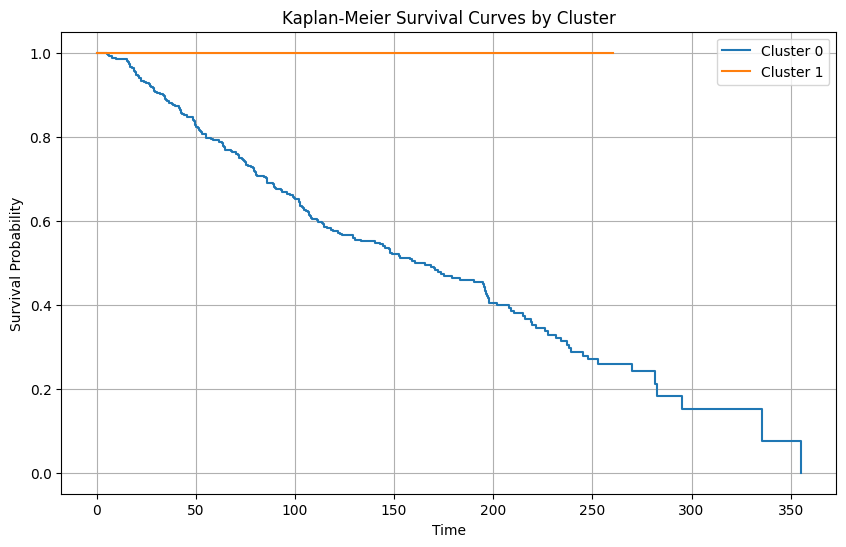

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import numpy as np

T = np.array(t_test)
E = np.array(e_test)

# Number of clusters from k-means
k = np.unique(clusters).shape[0]

# Create plot
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()

for cluster_id in range(k):
    idx = (clusters == cluster_id)
    if np.sum(idx) == 0:
        continue  # skip empty cluster

    kmf.fit(T[idx], event_observed=E[idx], label=f'Cluster {cluster_id}')
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan-Meier Survival Curves by Cluster")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()


**Sumo-net**

In [37]:
ss = MinMaxScaler().fit(t_train.reshape(-1, 1))
t_train_ddh = ss.transform(t_train.reshape(-1, 1)).flatten()
t_dev_ddh = ss.transform(t_dev.reshape(-1, 1)).flatten()
t_val_ddh = ss.transform(t_val.reshape(-1, 1)).flatten()
times_ddh = ss.transform(np.array(times).reshape(-1, 1)).flatten()

In [38]:
layers = [[50], [50, 50], [50, 50, 50], [100], [100, 100], [100, 100, 100]]
param_grid = {
            'learning_rate' : [1e-3, 1e-4],
            'layers_surv': layers,
            'layers' : layers,
            'batch': [100, 250],
            }
params = ParameterSampler(param_grid, 5, random_state = 42)

In [39]:
sys.path.append('/content/gdrive/My Drive/NeuralSurvivalClustering/Sumo/')

In [40]:
from sumo import SuMo
models = []
for param in params:
    model = SuMo(layers = param['layers'], layers_surv = param['layers_surv'])
    # The fit method is called to train the model
    model.fit(x_train, t_train_ddh, e_train, n_iter = 1000, bs = param['batch'],
            lr = param['learning_rate'], val_data = (x_dev, t_dev_ddh, e_dev))
    nll = model.compute_nll(x_val, t_val_ddh, e_val)
    if not(np.isnan(nll)):
        models.append([nll, model])
    else:
        print("WARNING: Nan Value Observed")

best_model = min(models, key = lambda x: x[0])
model = best_model[1]

Loss: 0.306:  40%|███▉      | 397/1000 [00:19<00:28, 20.86it/s]


In [41]:
out_risk = model.predict_risk(x_test, times_ddh.tolist())
out_survival = model.predict_survival(x_test, times_ddh.tolist())
print(out_risk)
print(out_survival)
print(out_risk.shape)
print(out_survival.shape)

[[0.23204519 0.56176289 0.8560143 ]
 [0.20467033 0.39166567 0.55726725]
 [0.50333402 0.6915802  0.86223367]
 ...
 [0.11943894 0.34577633 0.55462761]
 [0.27988064 0.45905665 0.53123789]
 [0.2729323  0.44390549 0.5612101 ]]
[[0.76795481 0.43823711 0.1439857 ]
 [0.79532967 0.60833433 0.44273275]
 [0.49666598 0.3084198  0.13776633]
 ...
 [0.88056106 0.65422367 0.44537239]
 [0.72011936 0.54094335 0.46876211]
 [0.7270677  0.55609451 0.4387899 ]]
(381, 3)
(381, 3)


In [42]:

cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, times)[1])
#roc_auc = []
#for i, _ in enumerate(times):
    #roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    #print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.6482558871588682
Brier Score: 0.11877391897608111
For 0.5 quantile,
TD Concordance Index: 0.6313121336979189
Brier Score: 0.20058174538803106
For 0.75 quantile,
TD Concordance Index: 0.6379315446576087
Brier Score: 0.21425871347657394


# **Deep Hit, DeepSurv, Cox **

In [43]:
!pip install pycox torchtuples


In [44]:
from pycox.datasets import metabric
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from torchtuples import optim

from pycox.models import DeepHitSingle
from pycox.models.loss import DeepHitSingleLoss
from pycox.evaluation import EvalSurv
from torchtuples import optim
import torchtuples as tt
import numpy as np
import torch

# Recall Datasets for value

from nsc import datasets
x, t, e, columns = datasets.load_dataset('SUPPORT')
from sklearn.model_selection import train_test_split

x_train, x_test, t_train, t_test, e_train, e_test = train_test_split(x, t, e, test_size=0.2, random_state=42)
x_train, x_val, t_train, t_val, e_train, e_val = train_test_split(x_train, t_train, e_train, test_size=0.2, random_state=42)
x_dev, x_val, t_dev, t_val, e_dev, e_val = train_test_split(x_val, t_val, e_val, test_size=0.5, random_state=42)

labtrans = DeepHitSingle.label_transform(100)

y_train = labtrans.fit_transform(t_train, e_train)
y_dev = labtrans.transform(t_dev, e_dev)
y_val = labtrans.transform(t_val, e_val)
y_test = labtrans.transform(t_test, e_test)

x_train = x_train.astype('float32')
x_dev = x_dev.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
print("Check X_train shape.", x_train.shape)


Check X_train shape. (5827, 44)


In [45]:
# DeepHit Model traning
# Check Input
print("Input shape:", x_train.shape)

# in-features
in_features = x_train.shape[1]
num_nodes = [100, 100]
out_features = labtrans.out_features

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, activation=torch.nn.ReLU)

model = DeepHitSingle(net, optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)

# train
model.fit(
    x_train.astype('float32'), y_train,
    batch_size=256,
    epochs=100,
    val_data=(x_dev.astype('float32'), y_dev),
    verbose=True
)

Input shape: (5827, 44)
0:	[0s / 0s],		train_loss: 0.9932,	val_loss: 0.9913
1:	[0s / 0s],		train_loss: 0.9351,	val_loss: 0.9625
2:	[0s / 0s],		train_loss: 0.9006,	val_loss: 0.9501
3:	[0s / 0s],		train_loss: 0.8729,	val_loss: 0.9334
4:	[0s / 0s],		train_loss: 0.8481,	val_loss: 0.9256
5:	[0s / 1s],		train_loss: 0.8279,	val_loss: 0.9215
6:	[0s / 1s],		train_loss: 0.8056,	val_loss: 0.9230
7:	[0s / 1s],		train_loss: 0.7859,	val_loss: 0.9109
8:	[0s / 1s],		train_loss: 0.7654,	val_loss: 0.9129
9:	[0s / 1s],		train_loss: 0.7467,	val_loss: 0.9051
10:	[0s / 2s],		train_loss: 0.7293,	val_loss: 0.9184
11:	[0s / 2s],		train_loss: 0.7096,	val_loss: 0.9314
12:	[0s / 2s],		train_loss: 0.6921,	val_loss: 0.9442
13:	[0s / 2s],		train_loss: 0.6759,	val_loss: 0.9618
14:	[0s / 3s],		train_loss: 0.6617,	val_loss: 0.9540
15:	[0s / 3s],		train_loss: 0.6468,	val_loss: 1.0042
16:	[0s / 3s],		train_loss: 0.6346,	val_loss: 0.9976
17:	[0s / 3s],		train_loss: 0.6193,	val_loss: 1.0313
18:	[0s / 3s],		train_loss: 0.61

In [46]:
# Predict survival function for test data
surv_df = model.predict_surv_df(x_test)

# Transpose to get shape (num_samples, time_steps)
surv_probs_deephit = surv_df.T.values

# Compute risk scores as (1 - survival probability)
risk_scores_deephit = 1 - surv_probs_deephit

print("Survival shape:", surv_probs_deephit.shape)
print("Risk shape:", risk_scores_deephit.shape)
print(surv_probs_deephit)
print(risk_scores_deephit)

# Get the model's internal time bin cut points
cut_times = model.duration_index

# Find the indices of the closest time bins for each evaluation horizon
idxs = [np.abs(cut_times - t).argmin() for t in times_ddh]

# Extract survival probabilities and risk scores at selected evaluation times
surv_probs_sampled = surv_probs_deephit[:, idxs]
risk_scores_sampled = risk_scores_deephit[:, idxs]

print(surv_probs_sampled.shape)  # Expected: (num_samples, 3)
print(risk_scores_sampled.shape)  # Expected: (num_samples,_


Survival shape: (1821, 100)
Risk shape: (1821, 100)
[[9.9771237e-01 9.9753690e-01 9.9260575e-01 ... 1.0883629e-02
  9.8274946e-03 1.7431378e-03]
 [9.9952316e-01 9.9797058e-01 7.5514251e-01 ... 2.9126704e-02
  2.6919782e-02 7.0649385e-04]
 [9.9951762e-01 9.9324811e-01 9.6888727e-01 ... 3.0695200e-03
  2.0576119e-03 1.3193488e-03]
 ...
 [9.9864084e-01 9.9863619e-01 9.9644744e-01 ... 5.6499243e-04
  5.5336952e-04 3.9273500e-04]
 [9.9970913e-01 9.9898493e-01 9.9775296e-01 ... 8.1108212e-03
  8.0494881e-03 6.6161156e-04]
 [9.9999183e-01 7.8663158e-01 7.7611148e-01 ... 1.7050350e-01
  1.3898969e-02 1.0782480e-03]]
[[2.2876263e-03 2.4631023e-03 7.3942542e-03 ... 9.8911637e-01
  9.9017251e-01 9.9825686e-01]
 [4.7683716e-04 2.0294189e-03 2.4485749e-01 ... 9.7087330e-01
  9.7308022e-01 9.9929351e-01]
 [4.8238039e-04 6.7518950e-03 3.1112731e-02 ... 9.9693048e-01
  9.9794239e-01 9.9868065e-01]
 ...
 [1.3591647e-03 1.3638139e-03 3.5525560e-03 ... 9.9943501e-01
  9.9944663e-01 9.9960726e-01]
 [2.908

In [47]:
# Result Data sets
from sksurv.metrics import (
    concordance_index_ipcw,
    brier_score,
    cumulative_dynamic_auc
)
import numpy as np

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                    dtype=[('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                   dtype=[('e', bool), ('t', float)])

# Evaluation
cis = []
brs = []
#roc_auc = []

for i, t_q in enumerate(times):
    # Time-dependent C-index
    ci = concordance_index_ipcw(et_train, et_test, risk_scores_sampled[:, i], t_q)[0]
    cis.append(ci)

    # Time-dependent ROC AUC
    #auc = cumulative_dynamic_auc(et_train, et_test, risk_scores_sampled[:, i], t_q)[0]
    #roc_auc.append(auc)

# Brier Score for all times at once
bs_all = brier_score(et_train, et_test, surv_probs_sampled, times)[1]
brs.append(bs_all)

# Display
for i, q in enumerate(horizons):
    print(f"For quantile q={q} (t={times[i]:.2f}):")
    print("TD Concordance Index:", cis[i])
    print("Brier Score:", brs[0][i])
    #print("ROC AUC:", roc_auc[i], "\n")


For quantile q=0.25 (t=42.68):
TD Concordance Index: 0.39670784535098386
Brier Score: 0.2929613832859484
For quantile q=0.5 (t=85.87):
TD Concordance Index: 0.4087236005637287
Brier Score: 0.3649153450108585
For quantile q=0.75 (t=145.33):
TD Concordance Index: 0.4177070827793164
Brier Score: 0.42927901971906796


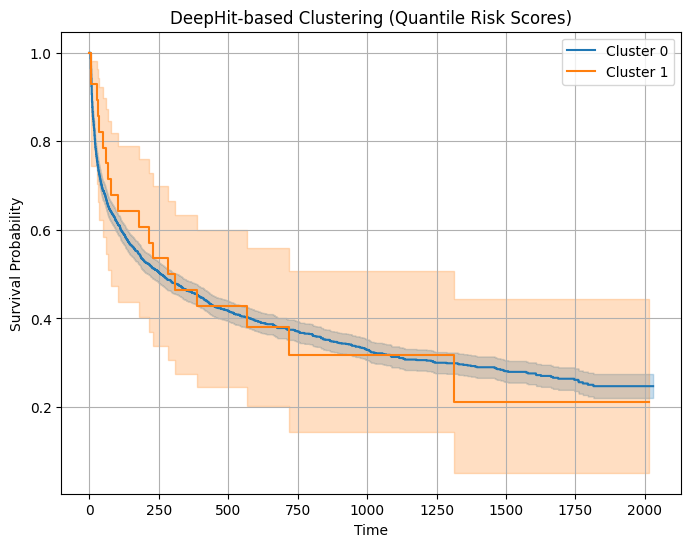

In [48]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import numpy as np

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(risk_scores_sampled)

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for cluster_id in np.unique(clusters):
    mask = clusters == cluster_id
    kmf.fit(t_test[mask], e_test[mask], label=f'Cluster {cluster_id}')
    kmf.plot_survival_function()

plt.title("DeepHit-based Clustering (Quantile Risk Scores)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()


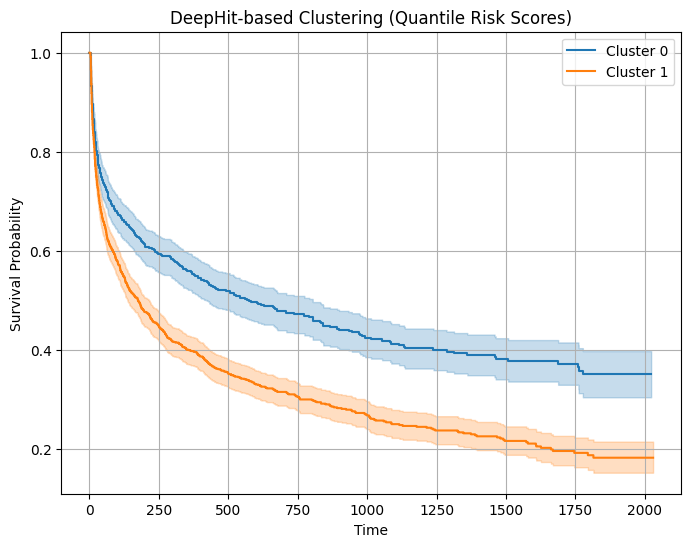

In [49]:
# Clusring for surv_probs_deephit
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(surv_probs_deephit)

# Step 2: KM Curve
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for cluster_id in np.unique(clusters):
    mask = clusters == cluster_id
    kmf.fit(t_test[mask], e_test[mask], label=f'Cluster {cluster_id}')
    kmf.plot_survival_function()

plt.title("DeepHit-based Clustering (Quantile Risk Scores)")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()


DeepSurv

In [50]:
# DeepSurv
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import torchtuples as tt
import torch
import numpy as np
# Convert time to float32 and features to float32
x_train = x_train.astype('float32')
x_dev = x_dev.astype('float32')
x_test = x_test.astype('float32')

# Stack time and event into one tensor
y_train = np.array([t_train, e_train]).T
y_dev = np.array([t_dev, e_dev]).T

# Network
in_features = x_train.shape[1]
net = tt.practical.MLPVanilla(in_features, [100, 100], 1, activation=torch.nn.ReLU)

# Model
model = CoxPH(net, tt.optim.Adam)

# Fit
model.fit(x_train, (t_train, e_train), batch_size=256, epochs=100,
          val_data=(x_dev, (t_dev, e_dev)), verbose=True)

0:	[0s / 0s],		train_loss: 4.9578,	val_loss: 5.8916
1:	[0s / 0s],		train_loss: 4.8532,	val_loss: 5.8677
2:	[0s / 0s],		train_loss: 4.8211,	val_loss: 5.8649
3:	[0s / 0s],		train_loss: 4.7949,	val_loss: 5.8610
4:	[0s / 0s],		train_loss: 4.7728,	val_loss: 5.8559
5:	[0s / 0s],		train_loss: 4.7546,	val_loss: 5.8600
6:	[0s / 0s],		train_loss: 4.7352,	val_loss: 5.8659
7:	[0s / 0s],		train_loss: 4.7193,	val_loss: 5.8704
8:	[0s / 0s],		train_loss: 4.6981,	val_loss: 5.8788
9:	[0s / 1s],		train_loss: 4.6838,	val_loss: 5.8895
10:	[0s / 1s],		train_loss: 4.6619,	val_loss: 5.8900
11:	[0s / 1s],		train_loss: 4.6460,	val_loss: 5.8903
12:	[0s / 1s],		train_loss: 4.6257,	val_loss: 5.9099
13:	[0s / 1s],		train_loss: 4.6076,	val_loss: 5.8999
14:	[0s / 2s],		train_loss: 4.5954,	val_loss: 5.9217
15:	[0s / 2s],		train_loss: 4.5748,	val_loss: 5.9383
16:	[0s / 2s],		train_loss: 4.5540,	val_loss: 5.9321
17:	[0s / 2s],		train_loss: 4.5335,	val_loss: 5.9634
18:	[0s / 2s],		train_loss: 4.5197,	val_loss: 5.9736
19:

In [51]:
model.compute_baseline_hazards()
surv_df = model.predict_surv_df(x_test)
risk_scores = -model.predict(x_test).reshape(-1)

In [52]:
from sksurv.metrics import (
    concordance_index_ipcw,
    brier_score,
    cumulative_dynamic_auc
)

# Structured format
et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                    dtype=[('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                   dtype=[('e', bool), ('t', float)])

# Quantiles
times = np.array(np.quantile(t_train[e_train != 0], [0.25, 0.5, 0.75]))

# Risk scores for DeepSurv
risk_scores = -model.predict(x_test).reshape(-1)  # higher = riskier
surv_probs = surv_df.T.values  # shape (n_samples, n_times)

# Match survival probabilities to selected time indices
cut_times = surv_df.index.values  # model's internal time points
idxs = [np.abs(cut_times - t).argmin() for t in times]
surv_sampled = surv_probs[:, idxs]
risk_sampled = 1 - surv_sampled

# Evaluate
cis = []
#roc_auc = []
for i, t in enumerate(times):
    ci = concordance_index_ipcw(et_train, et_test, risk_sampled[:, i], t)[0]
    #auc = cumulative_dynamic_auc(et_train, et_test, risk_sampled[:, i], t)[0]
    cis.append(ci)
    #roc_auc.append(auc)

brs = brier_score(et_train, et_test, surv_sampled, times)[1]

# Display
for i, t in enumerate(times):
    print(f"Quantile q{i+1} (t={t:.2f}):")
    print(f"  TD Concordance Index: {cis[i]}")
    print(f"  Brier Score: {brs[i]}")
   # print(f"  ROC AUC: {roc_auc[i]}\n")


Quantile q1 (t=15.00):
  TD Concordance Index: 0.6773127257526876
  Brier Score: 0.15686245209633198
Quantile q2 (t=59.00):
  TD Concordance Index: 0.640750810706566
  Brier Score: 0.2681278170447623
Quantile q3 (t=252.00):
  TD Concordance Index: 0.6228150896360999
  Brier Score: 0.319685833003915


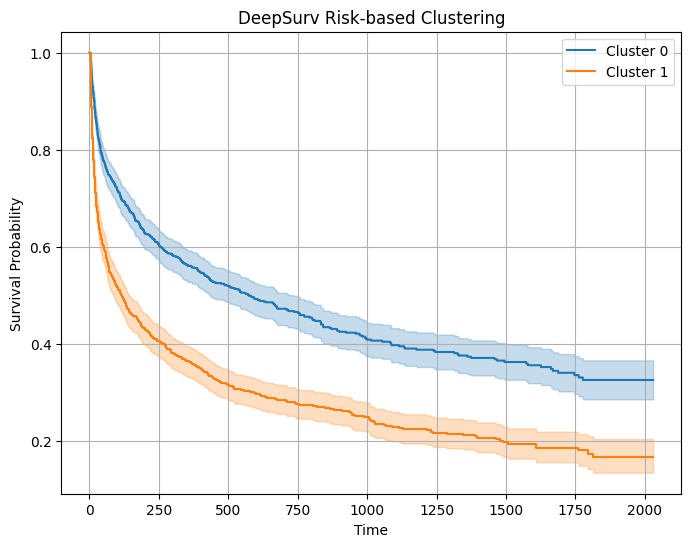

Silhouette Score: 0.5384994


In [53]:
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np

# Step 1: KMeans clustering on risk scores
risk_scores_reshape = risk_scores.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(risk_scores_reshape)

# Step 2: Plot Kaplan-Meier curves by cluster
kmf = KaplanMeierFitter()
plt.figure(figsize=(8,6))

for cluster_id in np.unique(clusters):
    mask = clusters == cluster_id
    kmf.fit(t_test[mask], e_test[mask], label=f'Cluster {cluster_id}')
    kmf.plot_survival_function()

plt.title("DeepSurv Risk-based Clustering")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()

from sklearn.metrics import silhouette_score

sil_score = silhouette_score(risk_scores_reshape, clusters)
print("Silhouette Score:", sil_score)


Cox Spritter

In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
# CosPHFitter

# 1. Standardize
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# 2. Remove low-variance features
selector = VarianceThreshold(threshold=1e-5)
x_train_filtered = selector.fit_transform(x_train_scaled)
x_test_filtered = selector.transform(x_test_scaled)

# 3. Remove high-correlation features
df_filtered = pd.DataFrame(x_train_filtered, columns=[f'x{i}' for i in range(x_train_filtered.shape[1])])
corr = df_filtered.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]

df_train_final = df_filtered.drop(columns=to_drop).copy()
df_train_final['T'] = t_train
df_train_final['E'] = e_train

df_test_final = pd.DataFrame(x_test_filtered, columns=df_filtered.columns).drop(columns=to_drop).copy()

# 4. Fit Cox with regularization
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_train_final, duration_col='T', event_col='E')

<lifelines.CoxPHFitter: fitted with 5827 total observations, 1874 right-censored observations>

In [55]:
# Predict risk scores using final filtered test set
risk_scores_cox = -cph.predict_partial_hazard(df_test_final).values  # higher = riskier
from sksurv.metrics import concordance_index_ipcw, cumulative_dynamic_auc

# Define evaluation time points
times = np.array(np.quantile(t_train[e_train != 0], [0.25, 0.5, 0.75]))

# Prepare structured arrays
et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                    dtype=[('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                   dtype=[('e', bool), ('t', float)])

# Evaluate
cis = []
#roc_auc = []
for i, t in enumerate(times):
    ci = concordance_index_ipcw(et_train, et_test, risk_scores_cox, t)[0]
    #auc = cumulative_dynamic_auc(et_train, et_test, risk_scores_cox, t)[0]
    cis.append(ci)
    #roc_auc.append(auc)

# Display results
for i, t in enumerate(times):
    print(f"CoxPH (final) at quantile q{i+1} (t={t:.2f}):")
    print(f"  TD Concordance Index: {cis[i]:.4f}")
    #print(f"  ROC AUC: {float(roc_auc[i]):.4f}")


CoxPH (final) at quantile q1 (t=15.00):
  TD Concordance Index: 0.2991
CoxPH (final) at quantile q2 (t=59.00):
  TD Concordance Index: 0.3320
CoxPH (final) at quantile q3 (t=252.00):
  TD Concordance Index: 0.3331


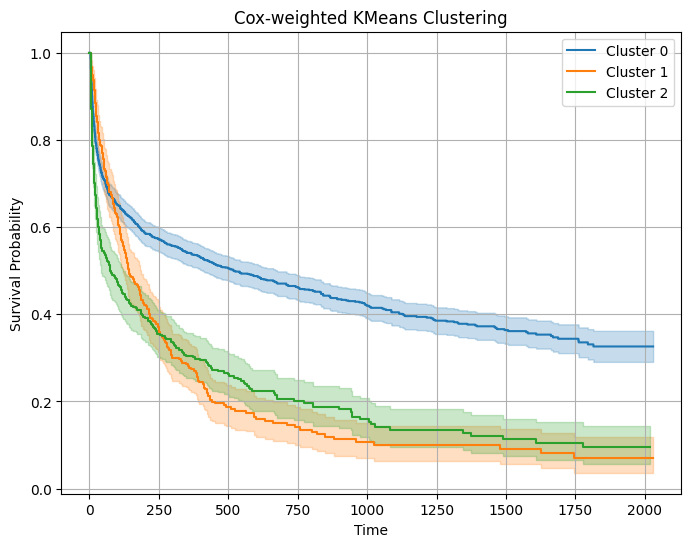

In [56]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

risk_scores = -cph.predict_partial_hazard(df_test_final).values.reshape(-1, 1)

scaler = StandardScaler()
x_features = scaler.fit_transform(df_test_final.values)  # only features
x_combined = np.hstack([x_features, risk_scores])  # [features | risk score]

kmeans = KMeans(n_clusters=3,  random_state=42)
clusters = kmeans.fit_predict(x_combined,sample_weight = e_test)

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

T = t_test
E = e_test
kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))
for cluster_id in np.unique(clusters):
    mask = clusters == cluster_id
    kmf.fit(T[mask], E[mask], label=f"Cluster {cluster_id}")
    kmf.plot_survival_function()

plt.title("Cox-weighted KMeans Clustering")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()
